# Analysis of Battleship Game

## Introduction

This article will try and analyse the game of the [Battleship](https://en.wikipedia.org/wiki/Battleship_(game)) board game. I try come put with a mathematically motivated strategy, inspired by an [article](https://austinrochford.com/posts/2021-09-02-battleship-bayes.html) by Anthony Rochford. I formalise these ideas in my own way, and build upon them to account for the opposing player's strategy.

We first import necassary packages and define some helper function

In [8]:
import numpy as np
import random
random.seed(42)

import seaborn as sns
import matplotlib.pylab as plt

In [9]:
def plot_probability_heatmap(heatmap):
    """Plot a heatmap of the probability of a ship being in each square."""
    plt.title('Probability of ship present on each tile')
    sns.heatmap(heatmap, linewidths=0.5, annot=True, cmap="mako", linecolor="black", cbar=True, vmin=0, vmax=1)
    plt.show()

## Modelling Game

We first come to the question of modelling the opponents board. First, however, notice that the game lies on a $10 \times 10$ grid. One approach is to model each tile as a seperate random variable. 

$$\text{Definition: } X^{(r,c)} \text{ represents the tile at row r and column c. } X^{(r,c)} = 1 \text{ if that tile is a ship } X^{(r,c)} = 0 \text{ otherwise.}$$

We represent the opponents board as a 2D array with value none if tile has no ship, and otherwise contains the string name of the ship as value.

In [10]:
# Opponent's Board
class OpponentBoard:
    def __init__(self):
        self.board = np.array([[None] * 10] * 10)
        self.ship_to_count = {}

    def __str__(self):
        return str(self.board)
    
    def is_hit(self, row, col):
        """Check if a shot is a hit. If it is a hit, track the number of remaining live tiles of ship. This assumed that row, col have not been guessed before."""
        if not self.board[row, col]:
            return False
        else:
            self.ship_to_count[self.board[row, col]] -= 1
            return True
    
    def is_sunk(self, ship_name):
        """Check if a ship has been sunk."""
        return self.ship_to_count[ship_name] == 0

    def place_ship(self, ship, row, col, is_vert):
        """Place a ship on the board. row, col are the top left corner of the ship.
            does not check wether ship is in bounds. 
            returns True if ship is placed, False if ship overlaps with another ship."""
        if is_vert:
            # Make sure ship does not overlap with other ships
            board_slice = self.board[row:row + ship.length, col]
            if np.any(board_slice):
                return False
            self.board[row:row + ship.length, col] = True
        else:
            # Make sure ship does not overlap with other ships
            board_slice = self.board[row, col:col + ship.length]
            if np.any(board_slice):
                return False
            self.board[row, col:col + ship.length] = True

        # Add ship to dictionary of placed ships
        self.ship_to_count[ship.name] = ship.length
        return True
        
    def reset_board(self):
        self.board = np.array([[None] * 10] * 10)
        self.ship_to_count = {}
    
    def generate_random_board(self, ships):
        """Generate the board with ships placed randomly."""

        # Reset board to place new ships
        self.reset_board()

        # Sequentially place ships
        for ship in ships:
            placed = False
            while not placed:
                is_vert = random.choice([True, False])
                row_max = 10 - ship.length if is_vert else 9
                col_max = 10 - ship.length if not is_vert else 9
                row, col =random.randint(0, row_max), random.randint(0, col_max)
                placed = self.place_ship(ship, row, col, is_vert)

    def plot_board(self):
        """Plot the board."""
        plt.title('Battleship board')
        mask = self.board != None
        sns.heatmap(mask, linewidths=0.5, cmap="tab20c", linecolor="black", cbar=False)
        plt.show()

We then have 5 types of ships: Carried, Battleship, Cruiser, Submarine and Destroyer. These have length 5, 4, 3, 3 and 2 respectively. 

In [11]:
class Ship:
    def __init__(self, name, length):
        self.name = name
        self.length = length

ships = [Ship("Carrier", 5), Ship("Battleship", 4), Ship("Cruiser", 3), Ship("Submarine", 3), Ship("Destroyer", 2)]

We can now initialise a new board and place a ship

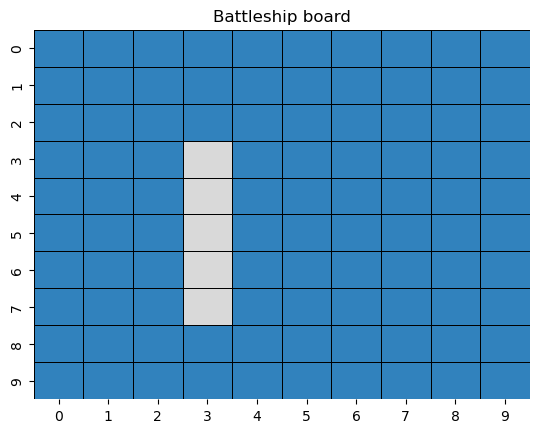

In [12]:
test_board = OpponentBoard()

# Lets place the Carrier at row 3, col 3
test_board.place_ship(ships[0], 3, 3, True)
test_board.plot_board()

Lets try randomly placing all our ships now

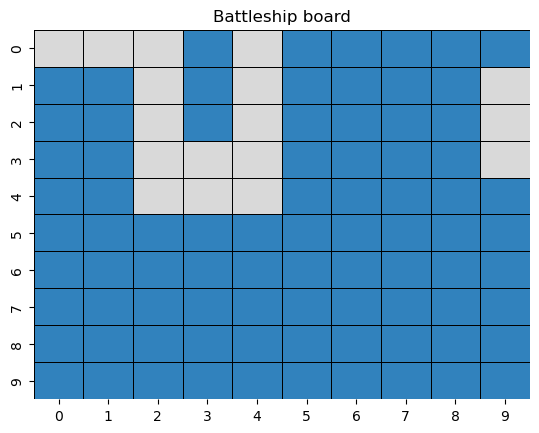

In [13]:
test_board.generate_random_board(ships) # note this function resets the board
test_board.plot_board()

## Computing the Probabilities

Notice that $X^{(r, c)} \sim Ber(\theta^{(r, c)})$. Hence, $P(X^{(r,c)} = 1) = \theta^{(r, c)}$ is the probability that tile (r, c) has a boat.

Also, we make no i.i.d assumptions for $X^{(r,c)}$ variables. Since, for example, if we know tile (r, c) has a ship, then we can conclude that adjacent tiles are more likely to be ships as well. In fact, this conditioning on known variables will guide our strategy.

Now, we need to find the values of $P(X^{(r,c)} = 1) = \theta^{(r,c)}$: the probability that the (r, c) tile contains a ship. We know that $X^{(r,c)} \sim Ber(\theta^{{(r,c)}})$. Hence, our maximum likelyhood estimator gives us:
$$P(X^{(r,c)} = 1) \approx \theta^{(r, c)}_{MLE} = \frac{1}{n} \sum_{i=1}^{n} x^{(r,c)}_i$$ 

where $x_i^{(r,c)}$ is our $i^{\text{th}}$ observation for the (r,c) tile from our monete carol. $n$ is the number of trails we do. 

Let's now caluculate these probabilities on out opponent's board.

In [14]:
def generate_heatmap(board, number_of_trials, conditions=None):
    """Generate a heatmap of the probability of a ship being in each square."""
    ship_count_heatmap = np.array([[0] * 10] * 10)
    for _ in range(number_of_trials):
        board.generate_random_board(conditions)
        ship_count_heatmap += board.board
    probability_heatmap = ship_count_heatmap / number_of_trials
    return probability_heatmap

n = 10**4
probability_heatmap = generate_heatmap(Board(ships), n)
plot_probability_heatmap(probability_heatmap)


NameError: name 'Board' is not defined

This makes sense. The centre tiles are much more likely to contain ships since there are many ways we can arrage ships in the centre, whereas there fewer ways near the borders. 

Now, what happends to these probabilities when we shoot at a tile? One way to approach this is by conditioning on the result. For example, lets assume we shoot the tile with row index 4 and column index 4. On no, we missed! Therefore, we now need to find $ P(X^{(r,c)} = 1 | X^{(4,4)} = 1) $. As before $ X^{(r,c)} | X^{(4, 4)} = 1 $ follows a bernouli distribution. Hence we can using our maximum likelyhood aproximator again to get:

$$P(X^{(r,c)} = 1 | X^{(4,4)} = 1) \approx \frac{1}{n} \sum_{i=1}^{n} x^{(r,c)}_i$$

$$\text{Subject to: } x^{(4,4)}_i = 1$$

An example board meeting this constraint is shown below. 

In [ ]:
board = Board(ships)

conditions = [(4, 4, True)]
board.generate_random_board(conditions)
plot_board(board)


We now run run a similair montecarlo to the one above, but now with our constaint that $ x^{(4,4)}_i = 1$.

In [ ]:
n = 10**4

conditions = [(4, 4, True)]
probability_heatmap = generate_heatmap(Board(ships), n, conditions)
plot_probability_heatmap(probability_heatmap)

This approach works for an arbitraty amount of conditions since we know that the random variable $X^{(r,c)} | C$ follows a bernoulli distibution for any set of conditions $C$.

For example, lets imaging we shoot tile (4, 4), (5, 5) and (3, 6) and miss all. Then the probability of each tile containing a ship would be as follows.

In [ ]:
n = 10**4

conditions = [(4, 4, False), (5, 5, False), (3, 6, False), (6, 3, True)]
probability_heatmap = generate_heatmap(Board(ships), n, conditions)
plot_probability_heatmap(probability_heatmap)

We have dealt with hits and misses; however, we have not yet considered the sinking of ships. When we hit all tiles of a opposing player's ship, the opposing player must annouce which ship we have sunk. Let's try considering this information in our model.

Abusing notation slightly, we can write the probability of a tile being a hit as given our knowlege of our previous turns and knowing which ships we sunk as:
$$P(X^{(r,c)} = 1 | X^{(r_0,c_0)} = i_0, ...,X^{(r_n,c_n)} = i_n, C)$$

where $C$ is the set of ship we have sunk so far. 

Now, lets try sinking a ship, and see a such a board would look like

In [ ]:
board = Board(ships)
board.sink_ship("Battleship", row=0, col=0, is_vert=False)
board.generate_random_board()
plot_board(board)

And lets see how this affects our probability heatmap.

In [ ]:
n = 10**4
probability_heatmap = generate_heatmap(board, n, conditions)
plot_probability_heatmap(probability_heatmap)

## Modelling Performance

Now lets not forget out goal: be the first to hit all 17 boat tiles of the opponent. One way to this is by minimising the time it takes to hit all ships. 

$$\text{Definition: } T_s \text{ is the number of turns it takes us to sink all 5 enemy ships with strategy }s\text{.}$$

We can therefore quantify the performance of our strategy using $E[T_s]$.

Note, however, $E[T_s]$ does not capture the entire picture regarding the success of a strategy: winning is dependent on the performance of the other player as well. For example, let's say player 1 has strategy $s_1$ and player 2 has strategy $s_2$, and $E[T_{s_1}] = E[T_{s_2}]$. Then, $s_1$ might be a better strategy than $s_2$ if $var[T_{s_1}] > var[T_{s_2}]$. However, this is simply an intuition and will be proven and/or tested.

It's difficult for us to determine $E[T_s]$ without knowing its distribution, so for know we simply assume that $E[T_s] \approx \bar{T_s}$.


## Strategy

Before developing out strategy, we must emphasise that we have made one, rather sever, assumtions. That the opposing player places their ships randomly initially. However, for now lets assume this is true, and then we'll see how we can adapt out apporach later.

At each stage of the game we have the probability of a ship on each tile. Using this information we must find an approach of choosing the next tile to target. We layout two inuitive strategies for this, including randomly shooting tiles to create a benchmark.

Random Strategy ($s_0$): Randmly choosing the next tile to shoot. 

Maximum Porbability ($s_1$): An obvious approach would be to choose tile with the maximum probability. 

Weighted Probabilities ($s_2$): Another might be to choose a tile randomly but linearly weighted based on each respective probability. This might lead to higher variance in $T_{s_1}$.

### Random Strategy ($s_0$)

In [ ]:
def count_turns_random_strategy(opposing_board):
    available_tiles = []

    for i in range(10):
        for j in range(10):
            available_tiles.append((i, j))

    hit_count = 0
    total_turns = 0
    while hit_count < 17:
        row, col = random.choice(available_tiles)
        available_tiles.remove((row, col))
        if opposing_board.board[row, col]:
            hit_count += 1
        total_turns += 1
    return total_turns

opposing_board = Board(ships)

num_trials = 10**4
total_turns = 0
for _ in range(num_trials):
    opposing_board.generate_random_board()
    turns = count_turns_random_strategy(opposing_board)
    total_turns += turns
    
sample_mean = total_turns / num_trials
print(f"Average number of turns: {sample_mean:.2f}")

### Maximum Porbability ($s_1$)

#### Example Game

In [ ]:
# Opponent board we play against
opposing_board = Board(ships)
opposing_board.generate_random_board()
plot_board(opposing_board)

In [ ]:
old_tracker = opposing_board.board.copy()
tracker = np.array([[False] * 10] * 10)

conditions = []

available_tiles = []
for i in range(10):
    for j in range(10):
        available_tiles.append((i, j))

hit_count = 0
while hit_count < 17:
    probability_heatmap = generate_heatmap(opposing_board, number_of_trials=10**4, conditions=conditions)
    plot_probability_heatmap(probability_heatmap)
    row, col = max(available_tiles, key=lambda x: probability_heatmap[x[0]][x[1]])
    available_tiles.remove((row, col))
    if old_tracker.board[row, col]:
        hit_count += 1
        # Hit
        conditions.append((row, col, True))

        # Update my view of the opposing board
        tracker[row, col] = True
        print(f"Hit: {row}, {col}")

        # Check that one of of my alive ships has sunk
        for ship in opposing_board.alive_ships:
            # TODO: This makes no sense; i need to look at the ships alive on the opposing board. Im passing around vairables.
            # EAch function call is changing the values of ship. I should my my boards immutable 
            if ship.is_vert:
                board_slice = tracker[ship.row:ship.row + ship.length, ship.col]
            else:
                board_slice = tracker[ship.row, ship.col:ship.col + ship.length]

            if np.all(board_slice):
                my_view_opposing_board.sink_ship(ship.name, ship.row, ship.col, ship.is_vert)
                print(f"Sunk {ship.name}")
                break
    else:
        print(f"Miss: {row}, {col}")
        conditions.append((row, col, False))


